In [133]:
import pandas as pd
from scipy.optimize import minimize


In [134]:
# Replace 'data.csv' with the path to your CSV file
df_train = pd.read_csv('ecallisto_radio_sunburst_train.csv')
df_val = pd.read_csv('ecallisto_radio_sunburst_test.csv')



In [135]:
df_train

,Unnamed: 0,manual_label,start_datetime,antenna,pred
0,0,0,2023-04-01 23:02:00,ALASKA-COHOE_63,-2.003801
1,1,0,2024-01-18 22:42:00,ALASKA-COHOE_63,-2.017155
2,2,0,2023-01-22 22:34:00,ALASKA-COHOE_63,-2.035397
3,3,0,2022-12-29 22:59:00,ALASKA-COHOE_63,-1.961941
4,4,0,2023-10-03 01:48:00,ALASKA-COHOE_63,-2.032514
...,...,...,...,...,...
243663,243663,1,2023-05-13 00:09:00,USA-ARIZONA-ERAU_01,0.656055
243664,243664,1,2023-03-22 19:50:00,USA-ARIZONA-ERAU_01,-0.285589
243665,243665,1,2022-09-30 17:46:00,USA-ARIZONA-ERAU_01,1.011232
243666,243666,1,2023-07-15 22:51:00,USA-ARIZONA-ERAU_01,1.493169


Optimal Temperature: 0.4974


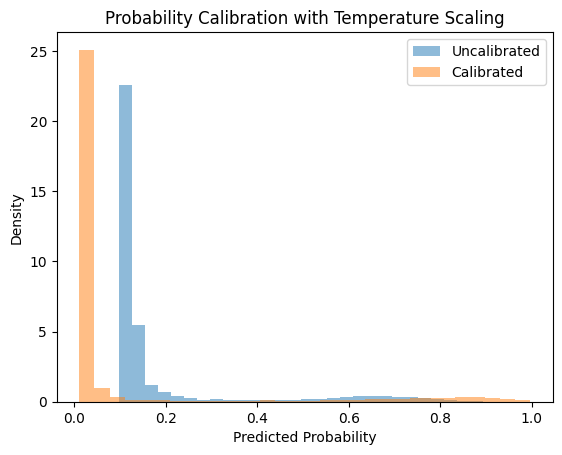

In [136]:

import numpy as np 
def sigmoid(x, T):
    return 1 / (1 + np.exp(-x / T))

import numpy as np
from scipy.optimize import minimize

# Example: logits and true labels (replace with your own)
# logits: unscaled model outputs before softmax or sigmoid
# labels: true labels (0 or 1 for binary classification)
logits = df_val['pred']
labels = df_val['manual_label']

# Define the temperature scaling objective (negative log-likelihood)
def temperature_nll(temp):
    temp = temp[0]
    probs = sigmoid(logits, temp)  # Adjust probabilities with temperature
    nll = -np.mean(labels * np.log(probs) + (1 - labels) * np.log(1 - probs))
    return nll

# Optimize temperature
initial_temp = np.array([1.0])  # Start with T = 1
result = minimize(temperature_nll, initial_temp, bounds=[(0.1, 10.0)])
optimal_temp = result.x[0]

print(f"Optimal Temperature: {optimal_temp:.4f}")

# Apply temperature scaling
calibrated_probs = sigmoid(logits, optimal_temp)

# Compare calibrated vs uncalibrated probabilities
import matplotlib.pyplot as plt
plt.hist(sigmoid(logits, 1), bins=30, alpha=0.5, label="Uncalibrated", density=True)
plt.hist(calibrated_probs, bins=30, alpha=0.5, label="Calibrated", density=True)
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.title("Probability Calibration with Temperature Scaling")
plt.show()



In [137]:
df_train['prob'] = df_train['pred'].apply(lambda x: sigmoid(x,0.4974))
df_val['prob'] = df_val['pred'].apply(lambda x: sigmoid(x,0.4974))

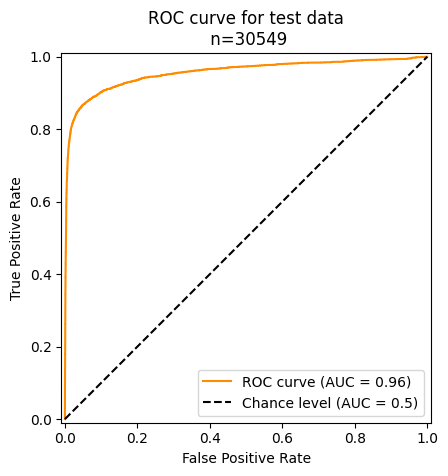

In [138]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

# Compute the frequency of each antenna
antenna_counts = df_val['antenna'].value_counts()
total_samples = len(df_val)

# Calculate weights (inverse of frequency)
df_val['antenna_weight'] = df_val['antenna'].map(lambda x: total_samples / antenna_counts[x])

display = RocCurveDisplay.from_predictions(
    df_val['manual_label'],
    df_val['prob'],
    name="ROC curve",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC curve for test data\n n={len(df_val)}",
)

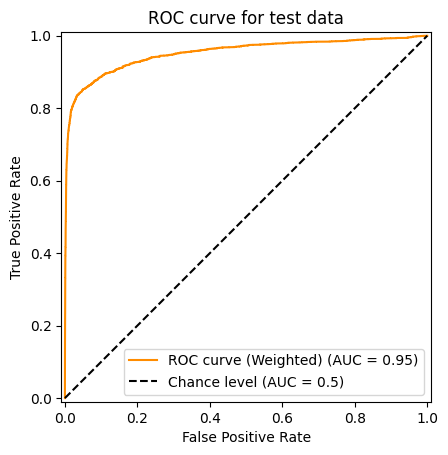

In [139]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

# Compute the frequency of each antenna
antenna_counts = df_val['antenna'].value_counts()
total_samples = len(df_val)

# Calculate weights (inverse of frequency)
df_val['antenna_weight'] = df_val['antenna'].map(lambda x: total_samples / antenna_counts[x])

display = RocCurveDisplay.from_predictions(
    df_val['manual_label'],
    df_val['prob'],
    sample_weight=df_val['antenna_weight'],
    name="ROC curve (Weighted)",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC curve for test data",
)

In [140]:
from sklearn.metrics import precision_recall_curve, auc

# Assume y_true (true labels) and y_scores (predicted probabilities) are available
precision, recall, thresholds = precision_recall_curve(df_val['manual_label'], df_val['prob'], sample_weight=df_val['antenna_weight'])

# Calculate area under the PR curve
pr_auc = auc(recall, precision)

# Find the threshold where precision > 0.65 and recall ≈ 1.0
threshold_info = [(t, p, r) for t, p, r in zip(thresholds, precision[:-1], recall[:-1]) if r > 0.5]

for t, p, r in threshold_info:
    if p > 0.95 and r > 0.6:
        print(f"Threshold: {t:.3f}, Precision: {p:.3f}, Recall: {r:.3f}")
        break


Threshold: 0.568, Precision: 0.950, Recall: 0.655


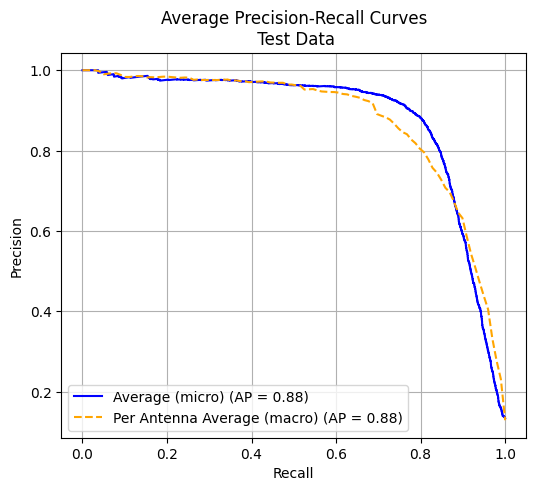

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Example dataset structure (replace this with your actual DataFrame)
# df = pd.DataFrame({
#     'manual_label': [...],  # True labels (0 or 1)
#     'prob': [...],          # Predicted probabilities (0 to 1)
#     'antenna': [...]        # Antenna identifiers
# })
df = df_val.copy()
# Group data by unique antennas
antennas = df['antenna'].unique()

# Macro-average Precision-Recall (unweighted average of all antennas)
precision_macro_list = []
recall_macro_list = []
auc_macro_list = []

for antenna in antennas:
    antenna_data = df[df['antenna'] == antenna]
    y_true = antenna_data['manual_label']
    y_score = antenna_data['prob']
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_macro_list.append(auc(recall, precision))  # Per-antenna AUC
    precision_macro_list.append(precision)
    recall_macro_list.append(recall)

# Combine to compute macro-average curve
# Interpolation is required because precision and recall arrays have different lengths
all_recalls = np.linspace(0, 1, 100)  # Interpolation points
macro_precisions = np.mean([
    np.interp(all_recalls, recall[::-1], precision[::-1]) for recall, precision in zip(recall_macro_list, precision_macro_list)
], axis=0)
macro_auc = auc(all_recalls, macro_precisions)

# Micro-average Precision-Recall (treat all antennas as one dataset)
y_true_combined = df['manual_label']
y_score_combined = df['prob']
precision_micro, recall_micro, _ = precision_recall_curve(y_true_combined, y_score_combined)
micro_auc = auc(recall_micro, precision_micro)

# Plot both macro and micro average PR curves
plt.figure(figsize=(6, 5))
plt.plot(recall_micro, precision_micro, label=f"Average (micro) (AP = {micro_auc:.2f})", linestyle='-', color='blue')
plt.plot(all_recalls, macro_precisions, label=f"Per Antenna Average (macro) (AP = {macro_auc:.2f})", linestyle='--', color='orange')


# Add plot details
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Average Precision-Recall Curves\n Test Data")
plt.legend(loc="lower left")
plt.grid()
plt.show()


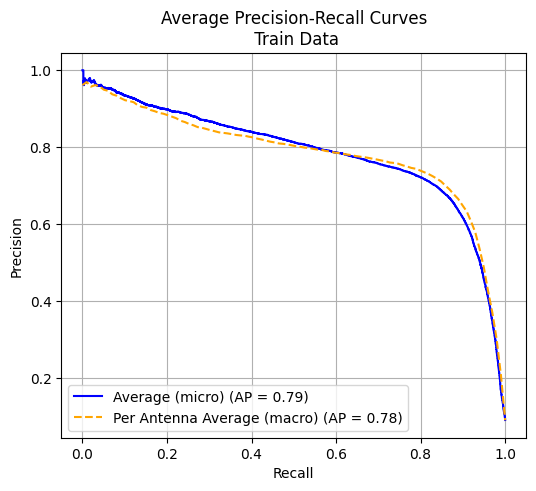

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Example dataset structure (replace this with your actual DataFrame)
# df = pd.DataFrame({
#     'manual_label': [...],  # True labels (0 or 1)
#     'prob': [...],          # Predicted probabilities (0 to 1)
#     'antenna': [...]        # Antenna identifiers
# })
df = df_train.copy()
# Group data by unique antennas
antennas = df['antenna'].unique()

# Macro-average Precision-Recall (unweighted average of all antennas)
precision_macro_list = []
recall_macro_list = []
auc_macro_list = []

for antenna in antennas:
    antenna_data = df[df['antenna'] == antenna]
    y_true = antenna_data['manual_label']
    y_score = antenna_data['prob']
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_macro_list.append(auc(recall, precision))  # Per-antenna AUC
    precision_macro_list.append(precision)
    recall_macro_list.append(recall)

# Combine to compute macro-average curve
# Interpolation is required because precision and recall arrays have different lengths
all_recalls = np.linspace(0, 1, 100)  # Interpolation points
macro_precisions = np.mean([
    np.interp(all_recalls, recall[::-1], precision[::-1]) for recall, precision in zip(recall_macro_list, precision_macro_list)
], axis=0)
macro_auc = auc(all_recalls, macro_precisions)

# Micro-average Precision-Recall (treat all antennas as one dataset)
y_true_combined = df['manual_label']
y_score_combined = df['prob']
precision_micro, recall_micro, _ = precision_recall_curve(y_true_combined, y_score_combined)
micro_auc = auc(recall_micro, precision_micro)

# Plot both macro and micro average PR curves
plt.figure(figsize=(6, 5))
plt.plot(recall_micro, precision_micro, label=f"Average (micro) (AP = {micro_auc:.2f})", linestyle='-', color='blue')
plt.plot(all_recalls, macro_precisions, label=f"Per Antenna Average (macro) (AP = {macro_auc:.2f})", linestyle='--', color='orange')

# Add plot details
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Average Precision-Recall Curves\n Train Data")
plt.legend(loc="lower left")
plt.grid()
plt.show()


In [146]:
df

,Unnamed: 0,manual_label,start_datetime,antenna,pred,prob
0,0,0,2023-04-01 23:02:00,ALASKA-COHOE_63,-2.003801,0.017489
1,1,0,2024-01-18 22:42:00,ALASKA-COHOE_63,-2.017155,0.017033
2,2,0,2023-01-22 22:34:00,ALASKA-COHOE_63,-2.035397,0.016430
3,3,0,2022-12-29 22:59:00,ALASKA-COHOE_63,-1.961941,0.018995
4,4,0,2023-10-03 01:48:00,ALASKA-COHOE_63,-2.032514,0.016524
...,...,...,...,...,...,...
243663,243663,1,2023-05-13 00:09:00,USA-ARIZONA-ERAU_01,0.656055,0.789010
243664,243664,1,2023-03-22 19:50:00,USA-ARIZONA-ERAU_01,-0.285589,0.360276
243665,243665,1,2022-09-30 17:46:00,USA-ARIZONA-ERAU_01,1.011232,0.884222
243666,243666,1,2023-07-15 22:51:00,USA-ARIZONA-ERAU_01,1.493169,0.952662


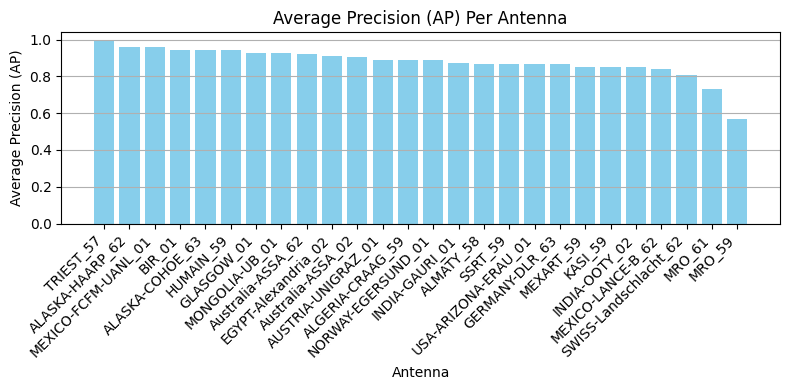

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Example dataset structure (replace this with your actual DataFrame)
# df = pd.DataFrame({
#     'manual_label': [...],  # True labels (0 or 1)
#     'prob': [...],          # Predicted probabilities (0 to 1)
#     'antenna': [...]        # Antenna identifiers
# })

df = df_val.copy()
# Group data by unique antennas
antennas = df['antenna'].unique()
ap_per_antenna = []

# Calculate Average Precision (AP) for each antenna
for antenna in antennas:
    antenna_data = df[df['antenna'] == antenna]
    y_true = antenna_data['manual_label']
    y_score = antenna_data['prob']
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_score) # sample_weight=antenna_data['antenna_weight'])
    ap = auc(recall, precision)  # Calculate AP (area under PR curve)
    ap_per_antenna.append((antenna, ap))

# Convert AP results to a DataFrame for plotting
ap_df = pd.DataFrame(ap_per_antenna, columns=["Antenna", "AP"]).sort_values(by="AP", ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 4))
plt.bar(ap_df["Antenna"], ap_df["AP"], color='skyblue')
plt.xlabel("Antenna")
plt.ylabel("Average Precision (AP)")
plt.title("Average Precision (AP) Per Antenna")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


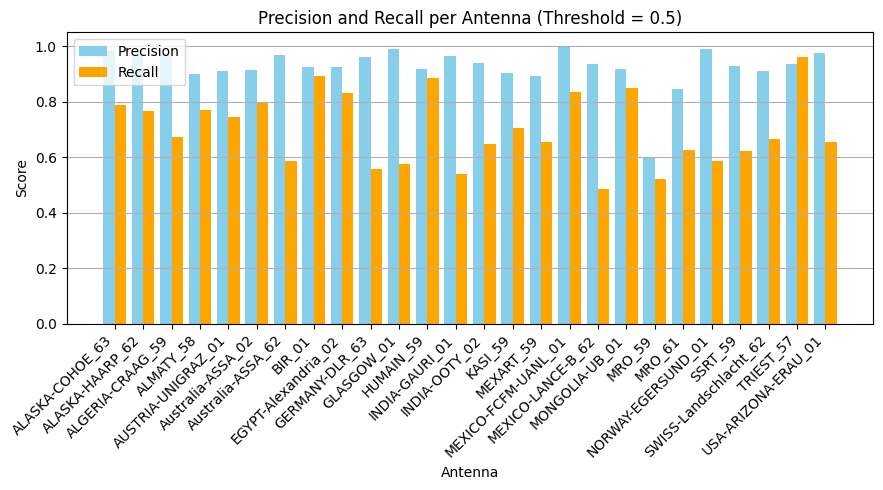

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Example dataset structure (replace this with your actual DataFrame)
# df = pd.DataFrame({
#     'manual_label': [...],  # True labels (0 or 1)
#     'prob': [...],          # Predicted probabilities (0 to 1)
#     'antenna': [...]        # Antenna identifiers
# })

df = df_val.copy()

antennas = df['antenna'].unique()
precision_list = []
recall_list = []
antenna_names = []

# Define a threshold for classification
threshold = 0.5

for antenna in antennas:
    antenna_data = df[df['antenna'] == antenna]
    y_true = antenna_data['manual_label'].values
    y_score = antenna_data['prob'].values

    # Binarize predictions at the chosen threshold
    y_pred = (y_score >= threshold).astype(int)

    # Compute precision and recall at this threshold
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))

    prec = tp / (tp + fp) if (tp + fp) else 0
    rec = tp / (tp + fn) if (tp + fn) else 0

    precision_list.append(prec)
    recall_list.append(rec)
    antenna_names.append(antenna)

# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Antenna': antenna_names,
    'Precision': precision_list,
    'Recall': recall_list
}).sort_values(by='Antenna')

# Plot side-by-side bars (grouped/paired barplot)
x = np.arange(len(results_df))
bar_width = 0.4

fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(x - bar_width/2, results_df['Precision'], width=bar_width, label='Precision', color='skyblue')
ax.bar(x + bar_width/2, results_df['Recall'], width=bar_width, label='Recall', color='orange')

ax.set_xticks(x)
ax.set_xticklabels(results_df['Antenna'], rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_xlabel('Antenna')
ax.set_title('Precision and Recall per Antenna (Threshold = 0.5)')
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()


In [59]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve

# Example DataFrame structure (replace with your actual data)
# df = pd.DataFrame({
#     'manual_label': [...],  # True labels (0 or 1)
#     'prob': [...],          # Predicted probabilities (0 to 1)
#     'antenna': [...]        # Antenna identifiers
# })

# Group data by unique antennas
antennas = df['antenna'].unique()
fixed_precision = 0.90  # Target precision
thresholds_for_fixed_precision = []

# Find thresholds for each antenna
for antenna in antennas:
    antenna_data = df[df['antenna'] == antenna]
    y_true = antenna_data['manual_label']
    y_score = antenna_data['prob']
    
    # Compute Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    
    # Find the threshold where precision >= fixed_precision
    idx = np.where(precision >= fixed_precision)[0]
    if len(idx) > 0:
        threshold = thresholds[idx[0]]  # Get the first threshold that satisfies the condition
        thresholds_for_fixed_precision.append((antenna, threshold))
    else:
        # If precision >= fixed_precision is not achievable, append None
        thresholds_for_fixed_precision.append((antenna, None))

# Aggregate thresholds
thresholds_df = pd.DataFrame(thresholds_for_fixed_precision, columns=["Antenna", "Threshold"])
average_threshold = thresholds_df['Threshold'].dropna().mean()

# Display results
print("Thresholds for Fixed Precision:")
print(thresholds_df)
print(f"Average Threshold Across Antennas (for Precision ≥ {fixed_precision}): {average_threshold:.4f}")


Thresholds for Fixed Precision:
                  Antenna  Threshold
0         ALASKA-COHOE_63   0.254600
1         ALASKA-HAARP_62   0.258008
2        ALGERIA-CRAAG_59   0.268408
3               ALMATY_58   0.533466
4      AUSTRIA-UNIGRAZ_01   0.467003
5       Australia-ASSA_02   0.459392
6       Australia-ASSA_62   0.247634
7                  BIR_01   0.387720
8     EGYPT-Alexandria_02   0.339338
9          GERMANY-DLR_63   0.250751
10             GLASGOW_01   0.249192
11              HUMAIN_59   0.455380
12         INDIA-GAURI_01   0.306378
13          INDIA-OOTY_02   0.371646
14                KASI_59   0.518808
15              MEXART_59   0.531845
16    MEXICO-FCFM-UANL_01   0.203533
17      MEXICO-LANCE-B_62   0.424454
18         MONGOLIA-UB_01   0.389246
19                 MRO_59   0.763854
20                 MRO_61   0.573691
21     NORWAY-EGERSUND_01   0.236404
22                SSRT_59   0.387752
23  SWISS-Landschlacht_62   0.484232
24              TRIEST_57   0.342766
25    

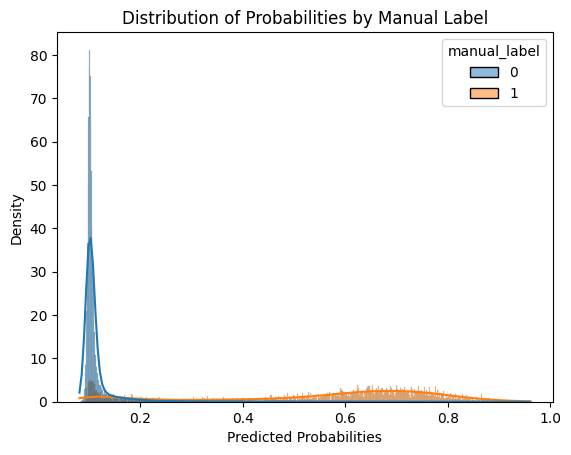

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'prob' and 'manual_label' columns
sns.histplot(
    data=df,
    x='prob',                # Column with probabilities
    hue='manual_label',      # Column with labels (0 or 1)
    kde=True,                # Optional: Add kernel density estimate
    stat="density",          # Normalize histogram
    common_norm=False        # Separate normalization per class
)

# Add plot labels
plt.xlabel("Predicted Probabilities")
plt.ylabel("Density")
plt.title("Distribution of Probabilities by Manual Label")
plt.show()


Optimal Temperature: 0.4974


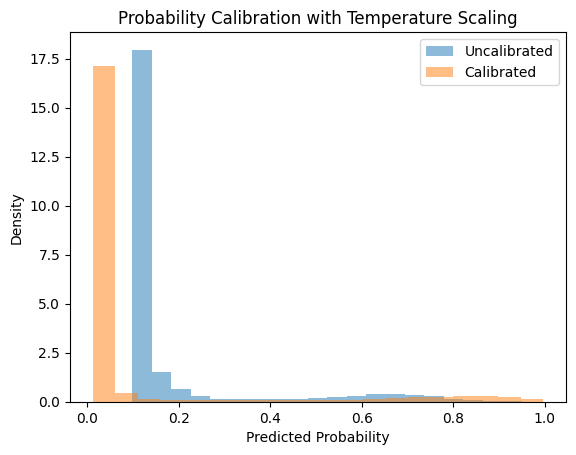

In [67]:
import numpy as np
from scipy.optimize import minimize

# Example: logits and true labels (replace with your own)
# logits: unscaled model outputs before softmax or sigmoid
# labels: true labels (0 or 1 for binary classification)
logits = df_val['pred']
labels = df_val['manual_label']

# Define the temperature scaling objective (negative log-likelihood)
def temperature_nll(temp):
    temp = temp[0]
    probs = sigmoid(logits, temp)  # Adjust probabilities with temperature
    nll = -np.mean(labels * np.log(probs) + (1 - labels) * np.log(1 - probs))
    return nll

# Optimize temperature
initial_temp = np.array([1.0])  # Start with T = 1
result = minimize(temperature_nll, initial_temp, bounds=[(0.1, 10.0)])
optimal_temp = result.x[0]

print(f"Optimal Temperature: {optimal_temp:.4f}")

# Apply temperature scaling
calibrated_probs = sigmoid(logits, optimal_temp)

# Compare calibrated vs uncalibrated probabilities
import matplotlib.pyplot as plt
plt.hist(sigmoid(logits, 1), bins=20, alpha=0.5, label="Uncalibrated", density=True)
plt.hist(calibrated_probs, bins=20, alpha=0.5, label="Calibrated", density=True)
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.title("Probability Calibration with Temperature Scaling")
plt.show()
